# Explore ECG dataset
Stefan/Yuzhao Heng
Since Sun. Oct. 31st, 2021


Check out data format of publicly available datasets & determine which to use.

e.g. If they contain 12-lead recordings, is each beat labeled


## Setup



In [1]:
import os
import glob

import pandas as pd
import wfdb
from wfdb import processing
from scipy.io import loadmat
from icecream import ic


from util import *


os.chdir('../../datasets')
!ls
dsets = list(config('datasets').keys())
ic(dsets)



CSPC-2018            KIT-20-PVC           PTB-XL
CSPC-2018-CinC       MIT-BIH-MVED         St-Petersburg-INCART
CSPC-2018-Extra-CinC PSTOV                Stef-Combined
Georgia-12-Lead      PTB-Diagnostic


ic| dsets: ['BIH_MVED',
            'INCART',
            'PTB_XL',
            'PTB_Diagnostic',
            'CSPC',
            'CSPC_CinC',
            'CSPC_Extra_CinC',
            'G12EC',
            'my']


['BIH_MVED',
 'INCART',
 'PTB_XL',
 'PTB_Diagnostic',
 'CSPC',
 'CSPC_CinC',
 'CSPC_Extra_CinC',
 'G12EC',
 'my']

## INCART
St Petersburg INCART 12-lead Arrhythmia Database


### Is the R-peak accurate, i.e. local maxima/minima?



In [ ]:
dset = config(f'datasets.{dsets[1]}')
ic(dset['nm'])
rnm = 'I01'
fnm = f'{dset["dir_nm"]}/{rnm}'
rec = wfdb.rdrecord(fnm)
ic(rec.p_signal.shape)
ic(rec.fs)

sampto = 2 ** 8
rec = wfdb.rdrecord(fnm, sampto=sampto)
ann = wfdb.rdann(fnm, extension='atr', sampto=sampto)

sig = rec.p_signal[:, 0]
idxs_rpeak = ann.sample
plot_rpeak(sig, idxs_rpeak, title=rnm)
idxs_rpeak = refine_rpeak(sig, idxs_rpeak, fqs=rec.fs)
plot_rpeak(sig, idxs_rpeak, title=f'{rnm}, refined peak')

## KIT-20-PVC
Human PVC and Paced beats (KIT-20-PVC_Clinical_1906-10-30)

BSPM data, not ECG


In [ ]:
# fnm = 'KIT-20-PVC/Interventions/InterventionPace1/Subject20_run01.mat'
# mat = loadmat(fnm)
# ic(mat)

fnm = 'KIT-20-PVC/Interventions/PVC/Subject20_run01.mat'
mat = loadmat(fnm)
data = mat['bspm']
ic(type(data), data.shape)

data = data[0][0]
ic(type(data), len(data))

data, unit, beat_type, file_nm = data
ic(data, unit, beat_type, file_nm)
ic(type(data), data.shape)



## PSTOV
[Multiple Ventricle Pacing Sites Pat#3 (Charles_PSTOV-12-07-29)](https://edgar.sci.utah.edu/human-pacing-site/11-charles_pstov-12-07-29.html)

Seems to only contain the QRS complex


In [ ]:
fnm = 'PSTOV/Interventions/interventionLeftVentPace01/2012-07-29Subject_run1'
mat = loadmat(fnm)
ic(mat)
data = mat['bspm']
ic(type(data), data.shape)

data = data[0][0]
ic(type(data), len(data))

data, unit, description = data
ic(data, unit, description)
ic(type(data), data.shape)

plot_single(data[0])



## PTB-XL
Looks like I need to detect R peaks myself



ic| dnm: 'PTB_XL'
ic| dset_['nm']: 'PTB-XL, a large publicly available electrocardiography dataset'
ic| rec_.p_signal.shape: (2048, 12)
ic| rec_.comments: []


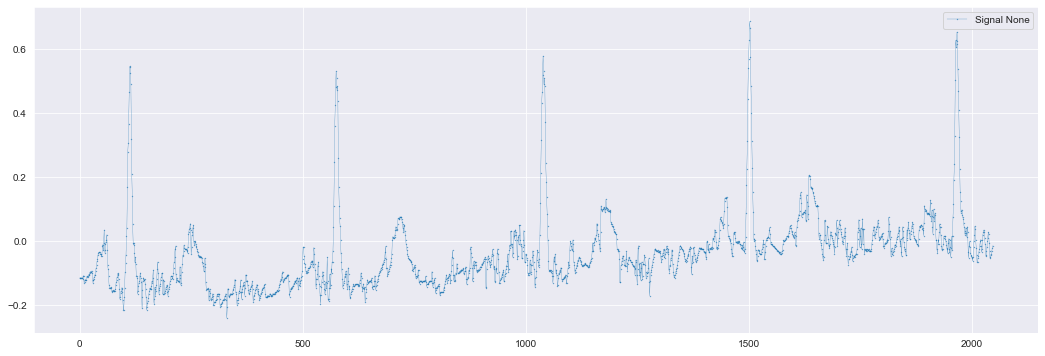

ic| hard_peaks.shape: (63,)
    hard_peaks[:20]: array([ 7,  9, 10, 17, 18, 27, 30, 49, 52, 53, 55, 57, 61, 71, 73, 74, 86,
                            90, 95, 99])
ic| soft_peaks.shape: (6,)
    soft_peaks[:20]: array([ 44,  68,  77, 184, 220, 236])


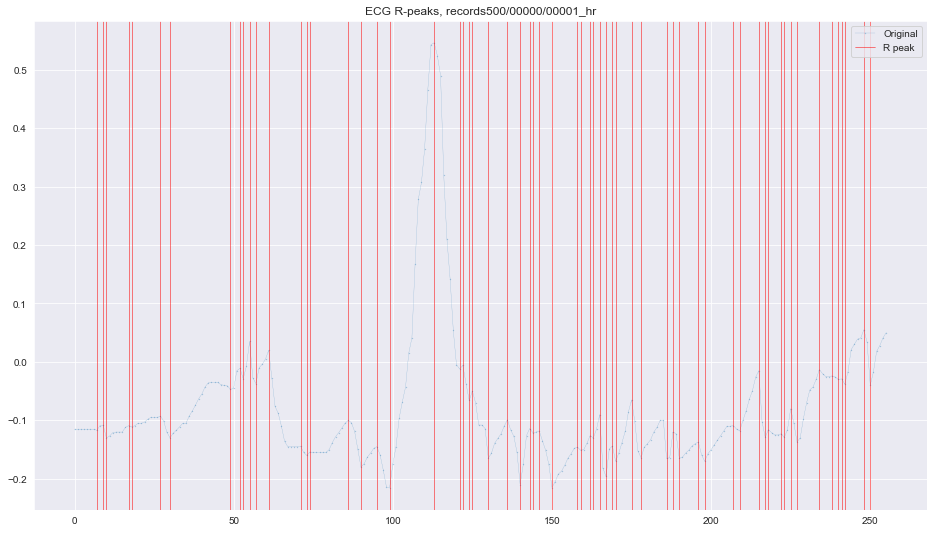

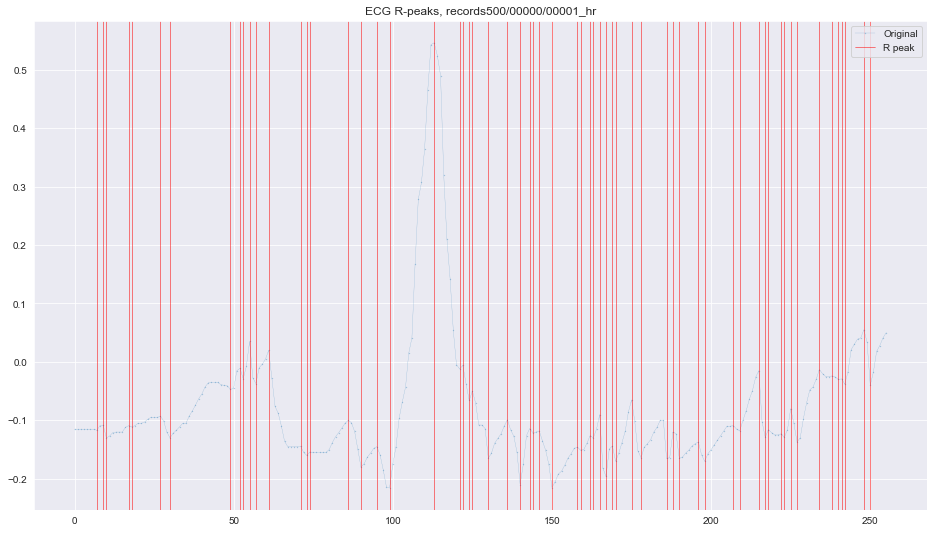

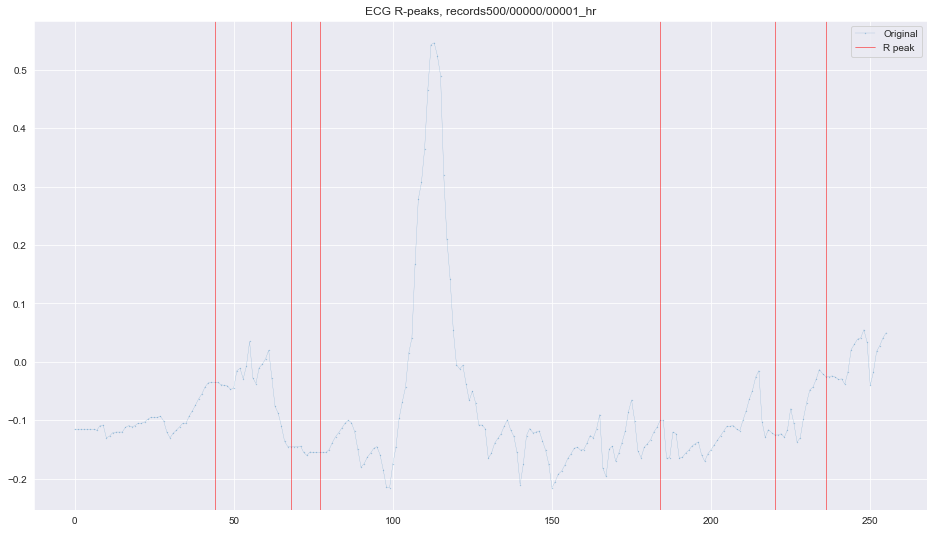

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr


In [15]:
def explore_singe_lead(dnm_, rnm_, sampto_=2**8):
    dset_ = config(f'{DIR_DSET}.{dnm_}')
    ic(dset_['nm'])

    fnm_ = f'{dset_["dir_nm"]}/{rnm_}'

    rec_ = wfdb.rdrecord(fnm_, sampto=sampto_ * 2**3)
    ic(rec_.p_signal.shape)
    ic(rec_.comments)

    sig_ = rec_.p_signal[:, 0]
    plot_single(sig_)

    rec_ = wfdb.rdrecord(fnm_, sampto=sampto_)
    sig_ = rec_.p_signal[:, 0]

    hard_peaks, soft_peaks = wfdb.processing.find_peaks(sig_)
    ic(hard_peaks.shape, hard_peaks[:20])
    ic(soft_peaks.shape, soft_peaks[:20])
    plot_rpeak(sig_, hard_peaks, title=rnm_)
    plot_rpeak(sig_, hard_peaks, title=rnm_)
    plot_rpeak(sig_, soft_peaks, title=rnm_)

dnm = dsets[2]
ic(dnm)
# R-peak from wfdb doesn't look good
explore_singe_lead(dnm, rnm_='records500/00000/00001_hr')

dir_nm = config(f'{DIR_DSET}.{dnm}.dir_nm')
path = f'{DIR_DSET}/{dir_nm}'
df = pd.read_csv(f'{PATH_BASE}/{path}/ptbxl_database.csv')
df.head(2)


## PTB-Diagnostic



In [ ]:
dnm = dsets[3]
explore_singe_lead(dnm, rnm_='patient001/s0010_re', sampto_=2**10)


CSPC-2018
China Physiological Signal Challenge 2018



In [ ]:
fnm = 'CSPC-2018/A0001.mat'
mat = loadmat(fnm)
ic(mat.keys())

data = mat['ECG']
ic(type(data), data.shape, data.dtype)
data = data[0][0]
ic(type(data), data.shape)
sex, age, sig = data
ic(sex, age, sig)
ic(sig.shape)
ic(sig[0, :20])


## CSPC-2018
But that from CinC


In [14]:
dnm = 'CSPC_CinC'
d_dset = config(f'{DIR_DSET}.{dnm}')
rnm = 'A0001'
ic(d_dset['nm'])

fnm = f'{d_dset["dir_nm"]}/{rnm}'
ic(fnm)

sampto = 2**8
rec = wfdb.rdrecord(fnm, sampto=sampto)
sig = rec.p_signal

ic(sig.shape)
ic(rec.d_signal)
ic(rec.record_name)
ic(rec.fs)
ic(rec.sig_name)
ic(rec.comments)

ic(sig[:20, 0])  # Differ by 0.0002288?

# ic(vars(rec))

ic| d_dset['nm']: 'China Physiological Signal Challenge 2018 - from CinC'
ic| fnm: 'CSPC-2018-CinC/A0001'
ic| sig.shape: (256, 12)
ic| rec.d_signal: None
ic| rec.record_name: 'A0001'
ic| rec.fs: 500
ic| rec.sig_name: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ic| rec.comments: ['Age: 74',
                   'Sex: Male',
                   'Dx: 59118001',
                   'Rx: Unknown',
                   'Hx: Unknown',
                   'Sx: Unknown']
ic| sig[:20, 0]: array([0.028, 0.039, 0.045, 0.049, 0.054, 0.056, 0.058, 0.06 , 0.06 ,
                        0.061, 0.065, 0.069, 0.073, 0.082, 0.087, 0.095, 0.104, 0.113,
                        0.121, 0.13 ])


array([0.028, 0.039, 0.045, 0.049, 0.054, 0.056, 0.058, 0.06 , 0.06 ,
       0.061, 0.065, 0.069, 0.073, 0.082, 0.087, 0.095, 0.104, 0.113,
       0.121, 0.13 ])

### What's `Dx` in the comments?
Class label for diagnosis?



In [13]:
dir_nm = d_dset['dir_nm']
path = f'{PATH_BASE}/{DIR_DSET}/{dir_nm}'
fmt = f'{path}/{d_dset["rec_fmt"]}'
recs = sorted(glob.iglob(fmt, recursive=True))
ic(recs[:5], len(recs))
dxs = [wfdb.rdrecord(fnm[:fnm.index('.')], sampto=1).comments[2] for fnm in recs]

ic(dxs[:5], len(dxs))
df = pd.DataFrame(dxs)
# uniqs = pd.unique(df[0])
# ic(list(uniqs), uniqs.size)
ic(df[0].value_counts())



ic| recs[:5]: ['/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/Georgia-12-Lead/E00001.mat',
               '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/Georgia-12-Lead/E00002.mat',
               '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/Georgia-12-Lead/E00003.mat',
               '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/Georgia-12-Lead/E00004.mat',
               '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/Georgia-12-Lead/E00005.mat']
    len(recs): 10344


HeaderSyntaxError: invalid syntax in record line

## CSPC-2018 extra
An unused dataset that's not publicly released from [original website](http://2018.icbeb.org/Challenge.html),
but available from CinC



In [12]:
dnm = 'CSPC_Extra_CinC'
dset_ = config(f'{DIR_DSET}.{dnm}')
rnm = 'Q0001'
ic(dset_['nm'])

fnm = f'{dset_["dir_nm"]}/{rnm}'
ic(fnm)

sampto = 2**8
rec = wfdb.rdrecord(fnm, sampto=sampto)
sig = rec.p_signal

ic(sig.shape)
ic(rec.d_signal)
ic(rec.record_name)
ic(rec.fs)
ic(rec.sig_name)
ic(rec.comments)

# ic(vars(rec))



ic| dset_['nm']: 'China Physiological Signal Challenge 2018, unused/extra - from CinC'
ic| fnm: 'CSPC-2018-Extra-CinC/Q0001'
ic| sig.shape: (256, 12)
ic| rec.d_signal: None
ic| rec.record_name: 'Q0001'
ic| rec.fs: 500
ic| rec.sig_name: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ic| rec.comments: ['Age: 53',
                   'Sex: Male',
                   'Dx: 164867002,427084000',
                   'Rx: Unknown',
                   'Hx: Unknown',
                   'Sx: Unknown']


['Age: 53',
 'Sex: Male',
 'Dx: 164867002,427084000',
 'Rx: Unknown',
 'Hx: Unknown',
 'Sx: Unknown']

## Georgia 12-Lead
Georgia 12-lead ECG Challenge (G12EC) Database



In [11]:
dnm = 'G12EC'
d_dset = config(f'{DIR_DSET}.{dnm}')
rnm = 'E00001'  # Looks like the header file is incorrect - `.mat` need to be processed
ic(d_dset['nm'])

fnm = f'{d_dset["dir_nm"]}/{rnm}'
sampto = 2**8
rec = wfdb.rdrecord(fnm, sampto=sampto)
sig = rec.p_signal
ic(rec)
ic(sig.shape)
# ic(vars(rec))
ic(rec.comments)



ic| d_dset['nm']: 'Georgia 12-lead ECG Challenge (G12EC) Database'
ic| rec: <wfdb.io.record.Record object at 0x1655f0eb0>
ic| sig.shape: (256, 12)
ic| rec.comments: ['Age: NaN', 'Sex: Female', 'Dx: 426783006', 'Rx: Unknown', 'Hx: Unknown']


['Age: NaN', 'Sex: Female', 'Dx: 426783006', 'Rx: Unknown', 'Hx: Unknown']